In [22]:
CURRENT_MODEL = "best_fid"  # Change this for each training run

DATASET_PATHS = {
    "original": "MOBIUS/Images",
    "best_fid": "MOBIUS_BEST_FID_GENERATED/Images",
    "latest_fid": "MOBIUS_LATEST_FID_GENERATED/Images",
}

OUTPUT_DIR = "results"

# DenseNet variant: '121', '169', '201', or '161' (DenseNet-161 is actually called densenet161)
DENSENET_VERSION = "121"

# Number of classes (subjects)
NUM_CLASSES = 100

# Use ImageNet pretrained weights
USE_PRETRAINED = True

# Training parameters
NUM_EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4

# Data split ratios
TEST_SIZE = 0.15
VAL_SIZE = 0.15
RANDOM_SEED = 42

# Learning rate scheduler
LR_SCHEDULER_PATIENCE = 5  # Reduce LR if no improvement for N epochs
LR_SCHEDULER_FACTOR = 0.5  # Multiply LR by this factor

# Early stopping
EARLY_STOPPING_PATIENCE = 15  # Stop if no improvement for N epochs

# Checkpoint settings
CHECKPOINT_FREQUENCY = 5  # Save checkpoint every N epochs
AUTO_SAVE_BEST = True  # Automatically save best model
RESUME_TRAINING = True  # Resume from last checkpoint if available

# Augmentation parameters
AUGMENTATION_CONFIG = {
    "resize": (256, 256),
    "crop_size": 224,
    "random_horizontal_flip": True,
    "flip_probability": 0.3,  # Be careful: might flip left/right eye
    "random_rotation_degrees": 10,
    "color_jitter": {"brightness": 0.2, "contrast": 0.2, "saturation": 0.2, "hue": 0.0},
}

# Number of workers for data loading
NUM_WORKERS = 4  # Set to 0 for CPU, 2-4 for GPU

# Mixed precision training (faster on T4/A100 GPUs)
USE_AMP = True  # Automatic Mixed Precision

# Exclude images marked as 'bad' in filename
EXCLUDE_BAD_IMAGES = True

# Mount Google Drive (will be handled in main code)
MOUNT_DRIVE = True

# Keep session alive settings
COLAB_KEEPALIVE = True  # Print progress to prevent timeout

print("=" * 60)
print(f"Configuration loaded for: {CURRENT_MODEL.upper()}")
print("=" * 60)
print(f"Dataset path: {DATASET_PATHS[CURRENT_MODEL]}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"DenseNet version: {DENSENET_VERSION}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Number of epochs: {NUM_EPOCHS}")
print(f"Resume training: {RESUME_TRAINING}")
print("=" * 60)

Configuration loaded for: BEST_FID
Dataset path: MOBIUS_BEST_FID_GENERATED/Images
Output directory: results
DenseNet version: 121
Batch size: 32
Learning rate: 0.001
Number of epochs: 30
Resume training: True


In [13]:
import sys
try:
    import torch
    import torchvision
    from sklearn.model_selection import train_test_split
    from tqdm import tqdm
    print("✓ All packages already installed")
except ImportError:
    print("Installing required packages...")
    !pip install torch torchvision scikit-learn tqdm pillow pandas matplotlib seaborn -q
    print("✓ Packages installed successfully")

import os
import re
import json
import time
from datetime import datetime
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from tqdm.auto import tqdm

✓ All packages already installed


In [23]:
def parse_filename(filename):
    """
    Parse MOBIUS filename to extract metadata
    Supports two formats:
    1. Original: '23_2i_Ls_1.jpg' -> {id: 23, phone: 2, light: 'i', eye: 'L', gaze: 's', number: '1'}
    2. Generated: 'generated_20.jpg' -> {id: extracted from parent folder, is_generated: True}
    """
    # Try original MOBIUS format first
    pattern_original = r"(\d+)_(\d)([inp])_([LR])([lrsu])_(\d+|bad)\.jpg"
    match = re.match(pattern_original, filename)

    if match:
        return {
            "subject_id": int(match.group(1)),
            "phone": int(match.group(2)),
            "light": match.group(3),
            "eye": match.group(4),
            "gaze": match.group(5),
            "number": match.group(6),
            "is_generated": False,
        }

    # Try generated image format: 'generated_20.jpg', 'generated_5.jpg', etc.
    pattern_generated = r"generated_\d+\.jpg"
    if re.match(pattern_generated, filename):
        # Subject ID will be extracted from parent folder name
        return {"is_generated": True, "filename_type": "generated"}

    return None


def load_dataset(data_dir, exclude_bad=True):
    """
    Load all images and extract metadata from a directory containing subject subfolders.
    Handles both original MOBIUS naming and generated image naming conventions.

    Args:
        data_dir: Path to the main image directory (containing subject subfolders).
        exclude_bad: Whether to exclude images marked as 'bad'.

    Returns:
        DataFrame with image paths and metadata.
    """
    if not os.path.exists(data_dir):
        raise ValueError(f"Dataset directory not found: {data_dir}")

    data = []
    subject_subdirs = [
        d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))
    ]

    if not subject_subdirs:
        raise ValueError(
            f"No subject subfolders found in {data_dir}. Expected 100 folders."
        )

    # Track statistics
    original_count = 0
    generated_count = 0

    for subdir in tqdm(subject_subdirs, desc="Loading subjects", leave=False):
        subdir_path = os.path.join(data_dir, subdir)

        # Extract subject ID from folder name (assuming folder name is the subject ID)
        try:
            folder_subject_id = int(subdir)
        except ValueError:
            print(
                f"⚠ Warning: Folder '{subdir}' doesn't appear to be a numeric subject ID, skipping..."
            )
            continue

        image_files = [f for f in os.listdir(subdir_path) if f.endswith(".jpg")]

        for filename in image_files:
            metadata = parse_filename(filename)

            if metadata:
                # For generated images, use folder name as subject_id
                if metadata.get("is_generated"):
                    metadata["subject_id"] = folder_subject_id
                    metadata["phone"] = None
                    metadata["light"] = None
                    metadata["eye"] = None
                    metadata["gaze"] = None
                    metadata["number"] = "generated"
                    generated_count += 1
                else:
                    # Verify subject_id matches folder name for original images
                    if metadata["subject_id"] != folder_subject_id:
                        print(
                            f"⚠ Warning: Subject ID mismatch - File '{filename}' (ID: {metadata['subject_id']}) in folder '{subdir}' (ID: {folder_subject_id})"
                        )

                    # Exclude bad images
                    if exclude_bad and metadata["number"] == "bad":
                        continue

                    original_count += 1

                metadata["filename"] = filename
                metadata["path"] = os.path.join(subdir_path, filename)
                data.append(metadata)

    if len(data) == 0:
        raise ValueError(f"No .jpg images found in any subfolder of {data_dir}")

    df = pd.DataFrame(data)

    print(f"✓ Loaded {len(df)} images from {len(df['subject_id'].unique())} subjects")
    if original_count > 0 and generated_count > 0:
        print(f"  - Original images: {original_count}")
        print(f"  - Generated images: {generated_count}")
        print(
            f"  - Mix ratio: {original_count/(original_count+generated_count)*100:.1f}% original, {generated_count/(original_count+generated_count)*100:.1f}% generated"
        )
    elif generated_count > 0:
        print(f"  - All images are generated")
    else:
        print(f"  - All images are original")

    return df


def save_checkpoint(
    model, optimizer, scheduler, epoch, val_acc, history, checkpoint_path, is_best=False
):
    """Save training checkpoint"""
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict() if scheduler else None,
        "val_acc": val_acc,
        "history": history,
        "timestamp": datetime.now().isoformat(),
    }

    torch.save(checkpoint, checkpoint_path)

    if is_best:
        best_path = checkpoint_path.replace("checkpoint", "best_model")
        torch.save(checkpoint, best_path)
        print(f"  ✓ Best model saved: {best_path}")


def load_checkpoint(checkpoint_path, model, optimizer=None, scheduler=None):
    """
    Load training checkpoint
    Compatible with both GPU and CPU
    """
    if not os.path.exists(checkpoint_path):
        return None

    print(f"Loading checkpoint from: {checkpoint_path}")

    # Load with map_location for CPU compatibility
    device = next(model.parameters()).device
    checkpoint = torch.load(checkpoint_path, map_location=device)

    model.load_state_dict(checkpoint["model_state_dict"])

    if optimizer and "optimizer_state_dict" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    if scheduler and checkpoint.get("scheduler_state_dict"):
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

    print(
        f"✓ Resumed from epoch {checkpoint['epoch']} (Val Acc: {checkpoint['val_acc']:.2f}%)"
    )

    return checkpoint

In [24]:
class MobiusDataset(Dataset):
    """MOBIUS Eye Dataset"""

    def __init__(self, image_paths, labels, transform=None):
        """
        Args:
            image_paths: List of image file paths
            labels: List of subject IDs (0-99)
            transform: torchvision transforms
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image as fallback
            image = Image.new("RGB", (224, 224), color="black")

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]

        return image, label

In [25]:
def prepare_data_loaders(df, batch_size, num_workers, augmentation_config):
    """
    Prepare train, validation, and test data loaders

    Returns:
        train_loader, val_loader, test_loader, splits_info
    """
    # Split data
    train_val_df, test_df = train_test_split(
        df, test_size=TEST_SIZE, stratify=df["subject_id"], random_state=RANDOM_SEED
    )

    val_ratio = VAL_SIZE / (1 - TEST_SIZE)
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_ratio,
        stratify=train_val_df["subject_id"],
        random_state=RANDOM_SEED,
    )

    print(
        f"✓ Data split - Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}"
    )

    # Define transforms
    train_transform = transforms.Compose(
        [
            transforms.Resize(augmentation_config["resize"]),
            transforms.RandomCrop(augmentation_config["crop_size"]),
            (
                transforms.RandomHorizontalFlip(
                    p=augmentation_config["flip_probability"]
                )
                if augmentation_config["random_horizontal_flip"]
                else transforms.Lambda(lambda x: x)
            ),
            transforms.RandomRotation(
                degrees=augmentation_config["random_rotation_degrees"]
            ),
            transforms.ColorJitter(**augmentation_config["color_jitter"]),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    val_test_transform = transforms.Compose(
        [
            transforms.Resize(
                (augmentation_config["crop_size"], augmentation_config["crop_size"])
            ),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    # Create datasets
    train_dataset = MobiusDataset(
        train_df["path"].tolist(),
        (train_df["subject_id"] - 1).tolist(),  # Convert to 0-indexed
        transform=train_transform,
    )

    val_dataset = MobiusDataset(
        val_df["path"].tolist(),
        (val_df["subject_id"] - 1).tolist(),
        transform=val_test_transform,
    )

    test_dataset = MobiusDataset(
        test_df["path"].tolist(),
        (test_df["subject_id"] - 1).tolist(),
        transform=val_test_transform,
    )

    # Create data loaders with CPU-compatible settings
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=(
            num_workers if torch.cuda.is_available() else 0
        ),  # Use 0 workers on CPU
        pin_memory=(
            True if torch.cuda.is_available() else False
        ),  # Only pin memory on GPU
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers if torch.cuda.is_available() else 0,
        pin_memory=True if torch.cuda.is_available() else False,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers if torch.cuda.is_available() else 0,
        pin_memory=True if torch.cuda.is_available() else False,
    )

    splits_info = {"train_df": train_df, "val_df": val_df, "test_df": test_df}

    return train_loader, val_loader, test_loader, splits_info

In [26]:
def create_densenet_classifier(num_classes, pretrained, densenet_version):
    """
    Create DenseNet model for classification

    Args:
        num_classes: Number of output classes
        pretrained: Use ImageNet pretrained weights
        densenet_version: '121', '169', '201', or '161'

    Returns:
        DenseNet model
    """
    if densenet_version == "121":
        model = models.densenet121(pretrained=pretrained)
    elif densenet_version == "169":
        model = models.densenet169(pretrained=pretrained)
    elif densenet_version == "201":
        model = models.densenet201(pretrained=pretrained)
    elif densenet_version == "161":
        model = models.densenet161(pretrained=pretrained)
    else:
        raise ValueError(f"Invalid DenseNet version: {densenet_version}")

    # Replace final classification layer
    num_features = model.classifier.in_features
    model.classifier = nn.Linear(num_features, num_classes)

    return model

In [27]:
def train_epoch(model, train_loader, criterion, optimizer, device, scaler=None):
    """
    Train for one epoch
    Compatible with both GPU (CUDA) and CPU
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc="Training", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Mixed precision training (only if scaler is provided and on CUDA)
        if scaler and torch.cuda.is_available():
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # Standard training (CPU or no AMP)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar
        pbar.set_postfix(
            {
                "loss": f"{running_loss/(pbar.n+1):.3f}",
                "acc": f"{100.*correct/total:.2f}%",
            }
        )

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100.0 * correct / total

    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device):
    """Validate model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_acc = 100.0 * correct / total

    return val_loss, val_acc


def train_model(model, train_loader, val_loader, device, model_name, config):
    """
    Complete training loop with checkpointing

    Returns:
        Training history
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="max",
        factor=LR_SCHEDULER_FACTOR,
        patience=LR_SCHEDULER_PATIENCE,
        # Removed 'verbose=True' as it's deprecated in newer PyTorch versions
    )

    # Mixed precision scaler (only for CUDA)
    scaler = (
        torch.cuda.amp.GradScaler() if USE_AMP and torch.cuda.is_available() else None
    )

    if scaler:
        print(f"✓ Using Automatic Mixed Precision (AMP) for faster training")
    else:
        if not torch.cuda.is_available():
            print(f"ℹ Running on CPU - AMP disabled")
        else:
            print(f"ℹ AMP disabled in configuration")

    # Checkpoint path
    checkpoint_path = os.path.join(OUTPUT_DIR, f"checkpoint_{model_name}.pth")

    # Try to resume
    start_epoch = 0
    best_val_acc = 0.0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if RESUME_TRAINING and os.path.exists(checkpoint_path):
        checkpoint = load_checkpoint(checkpoint_path, model, optimizer, scheduler)
        if checkpoint:
            start_epoch = checkpoint["epoch"] + 1
            best_val_acc = checkpoint["val_acc"]
            history = checkpoint["history"]
            print(f"✓ Resuming training from epoch {start_epoch}")

    # Early stopping
    patience_counter = 0

    print(f"\n{'='*60}")
    print(f"Starting training: {model_name}")
    print(f"Device: {device}")
    if torch.cuda.is_available():
        print(f"Mixed Precision (AMP): {USE_AMP}")
    else:
        print(f"Running on CPU (AMP not available)")
    print(f"{'='*60}\n")

    for epoch in range(start_epoch, NUM_EPOCHS):
        epoch_start_time = time.time()

        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        print("-" * 50)

        # Train
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device, scaler
        )

        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        # Update scheduler
        scheduler.step(val_acc)

        # Save history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        epoch_time = time.time() - epoch_start_time

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        print(f"Time: {epoch_time:.2f}s")

        # Save checkpoint
        is_best = val_acc > best_val_acc

        if is_best:
            best_val_acc = val_acc
            patience_counter = 0
            print(f"✓ New best validation accuracy: {val_acc:.2f}%")
        else:
            patience_counter += 1

        # Save regular checkpoint
        if (epoch + 1) % CHECKPOINT_FREQUENCY == 0 or is_best:
            save_checkpoint(
                model,
                optimizer,
                scheduler,
                epoch,
                val_acc,
                history,
                checkpoint_path,
                is_best=is_best,
            )
            print(f"  ✓ Checkpoint saved")

        # Early stopping
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(
                f"\n⚠ Early stopping triggered (no improvement for {EARLY_STOPPING_PATIENCE} epochs)"
            )
            break

        # Keep-alive for Colab
        if COLAB_KEEPALIVE:
            print(
                f'[Keep-Alive] Epoch {epoch+1} completed at {datetime.now().strftime("%H:%M:%S")}'
            )

    # Save final checkpoint
    save_checkpoint(
        model,
        optimizer,
        scheduler,
        epoch,
        val_acc,
        history,
        checkpoint_path,
        is_best=False,
    )

    print(f'\n{"="*60}')
    print(f"Training completed!")
    print(f"Best validation accuracy: {best_val_acc:.2f}%")
    print(f'{"="*60}\n')

    return history

In [28]:
def evaluate_model(model, test_loader, device, model_name):
    """
    Comprehensive evaluation on test set

    Returns:
        Dictionary with metrics
    """
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Testing {model_name}"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="macro", zero_division=0
    )

    # Top-5 accuracy
    top5_correct = 0
    for i, label in enumerate(all_labels):
        top5_preds = np.argsort(all_probs[i])[-5:]
        if label in top5_preds:
            top5_correct += 1
    top5_accuracy = top5_correct / len(all_labels)

    results = {
        "accuracy": accuracy * 100,
        "precision": precision * 100,
        "recall": recall * 100,
        "f1_score": f1 * 100,
        "top5_accuracy": top5_accuracy * 100,
        "predictions": all_preds,
        "labels": all_labels,
        "probabilities": all_probs,
    }

    return results


def save_results(results, history, model_name):
    """Save results and training history"""
    results_dir = os.path.join(OUTPUT_DIR, f"results_{model_name}")
    os.makedirs(results_dir, exist_ok=True)

    # Save metrics
    metrics = {
        "accuracy": float(results["accuracy"]),
        "top5_accuracy": float(results["top5_accuracy"]),
        "precision": float(results["precision"]),
        "recall": float(results["recall"]),
        "f1_score": float(results["f1_score"]),
    }

    with open(os.path.join(results_dir, "metrics.json"), "w") as f:
        json.dump(metrics, f, indent=4)

    # Save history
    with open(os.path.join(results_dir, "history.json"), "w") as f:
        json.dump(history, f, indent=4)

    # Save predictions
    np.save(os.path.join(results_dir, "predictions.npy"), results["predictions"])
    np.save(os.path.join(results_dir, "labels.npy"), results["labels"])
    np.save(os.path.join(results_dir, "probabilities.npy"), results["probabilities"])

    print(f"✓ Results saved to: {results_dir}")

In [29]:
def plot_training_curves(history, model_name):
    """Plot and save training curves"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    epochs = range(1, len(history["train_loss"]) + 1)

    # Loss
    axes[0].plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    axes[0].plot(epochs, history["val_loss"], label="Val Loss", marker="s")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title(f"Training Loss - {model_name}")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy
    axes[1].plot(epochs, history["train_acc"], label="Train Acc", marker="o")
    axes[1].plot(epochs, history["val_acc"], label="Val Acc", marker="s")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy (%)")
    axes[1].set_title(f"Training Accuracy - {model_name}")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()

    save_path = os.path.join(OUTPUT_DIR, f"training_curves_{model_name}.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"✓ Training curves saved: {save_path}")
    plt.show()


def plot_confusion_matrix(results, model_name, num_classes=100):
    """
    Plot and save detailed confusion matrix

    Args:
        results: Dictionary containing predictions and labels
        model_name: Name of the model for saving
        num_classes: Number of classes (default: 100)
    """
    from sklearn.metrics import confusion_matrix

    # Compute confusion matrix
    cm = confusion_matrix(
        results["labels"], results["predictions"], labels=range(num_classes)
    )

    # Calculate per-class accuracy
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    per_class_accuracy = np.nan_to_num(
        per_class_accuracy, nan=0.0
    )  # Handle division by zero

    print("\n" + "=" * 60)
    print("PER-CLASS PERFORMANCE ANALYSIS")
    print("=" * 60)

    # Find best and worst performing classes
    class_accuracies = [(i + 1, acc * 100) for i, acc in enumerate(per_class_accuracy)]
    class_accuracies.sort(key=lambda x: x[1], reverse=True)

    print("\n📊 Top 10 Best Performing Subjects:")
    print("-" * 50)
    for i, (subject_id, acc) in enumerate(class_accuracies[:10], 1):
        print(f"{i:2d}. Subject {subject_id:3d}: {acc:6.2f}% accuracy")

    print("\n⚠️  Top 10 Worst Performing Subjects:")
    print("-" * 50)
    for i, (subject_id, acc) in enumerate(class_accuracies[-10:], 1):
        print(f"{i:2d}. Subject {subject_id:3d}: {acc:6.2f}% accuracy")

    # Overall statistics
    print("\n📈 Overall Statistics:")
    print("-" * 50)
    print(f"Mean per-class accuracy: {np.mean(per_class_accuracy)*100:.2f}%")
    print(f"Std per-class accuracy:  {np.std(per_class_accuracy)*100:.2f}%")
    print(f"Min per-class accuracy:  {np.min(per_class_accuracy)*100:.2f}%")
    print(f"Max per-class accuracy:  {np.max(per_class_accuracy)*100:.2f}%")

    # Count samples per class
    samples_per_class = cm.sum(axis=1)
    print(
        f"\nSamples per class - Min: {samples_per_class.min()}, Max: {samples_per_class.max()}, Mean: {samples_per_class.mean():.1f}"
    )

    # Create visualizations
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

    # 1. Full confusion matrix (100x100)
    ax1 = fig.add_subplot(gs[0, :])

    # Normalize confusion matrix by row (true labels)
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized, nan=0.0)

    im = ax1.imshow(cm_normalized, cmap="Blues", aspect="auto", interpolation="nearest")
    ax1.set_title(
        f"Confusion Matrix (Normalized) - {model_name}", fontsize=16, fontweight="bold"
    )
    ax1.set_xlabel("Predicted Subject ID", fontsize=12)
    ax1.set_ylabel("True Subject ID", fontsize=12)

    # Set ticks
    tick_marks = np.arange(0, num_classes, 10)
    ax1.set_xticks(tick_marks)
    ax1.set_yticks(tick_marks)
    ax1.set_xticklabels([str(i + 1) for i in tick_marks])
    ax1.set_yticklabels([str(i + 1) for i in tick_marks])

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    cbar.set_label("Normalized Count", rotation=270, labelpad=20)

    # Add grid
    ax1.set_xticks(np.arange(num_classes) - 0.5, minor=True)
    ax1.set_yticks(np.arange(num_classes) - 0.5, minor=True)
    ax1.grid(which="minor", color="white", linestyle="-", linewidth=0.5, alpha=0.3)

    # 2. Per-class accuracy bar chart
    ax2 = fig.add_subplot(gs[1, 0])

    colors = [
        "green" if acc > 0.8 else "orange" if acc > 0.5 else "red"
        for acc in per_class_accuracy
    ]
    bars = ax2.bar(
        range(1, num_classes + 1), per_class_accuracy * 100, color=colors, alpha=0.7
    )
    ax2.axhline(
        y=np.mean(per_class_accuracy) * 100,
        color="blue",
        linestyle="--",
        linewidth=2,
        label=f"Mean: {np.mean(per_class_accuracy)*100:.1f}%",
    )
    ax2.set_xlabel("Subject ID", fontsize=12)
    ax2.set_ylabel("Accuracy (%)", fontsize=12)
    ax2.set_title("Per-Class Accuracy", fontsize=14, fontweight="bold")
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis="y")
    ax2.set_xlim(0, num_classes + 1)
    ax2.set_ylim(0, 105)

    # 3. Accuracy distribution histogram
    ax3 = fig.add_subplot(gs[1, 1])

    ax3.hist(
        per_class_accuracy * 100, bins=20, color="skyblue", edgecolor="black", alpha=0.7
    )
    ax3.axvline(
        x=np.mean(per_class_accuracy) * 100,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Mean: {np.mean(per_class_accuracy)*100:.1f}%",
    )
    ax3.set_xlabel("Accuracy (%)", fontsize=12)
    ax3.set_ylabel("Number of Subjects", fontsize=12)
    ax3.set_title("Distribution of Per-Class Accuracy", fontsize=14, fontweight="bold")
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis="y")

    plt.tight_layout()

    # Save confusion matrix visualization
    save_path = os.path.join(OUTPUT_DIR, f"confusion_matrix_{model_name}.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"\n✓ Confusion matrix saved: {save_path}")
    plt.show()

    # Save per-class accuracy as CSV
    accuracy_df = pd.DataFrame(
        {
            "Subject_ID": range(1, num_classes + 1),
            "Accuracy_%": per_class_accuracy * 100,
            "Samples": samples_per_class,
        }
    )
    accuracy_df = accuracy_df.sort_values("Accuracy_%", ascending=False)

    csv_path = os.path.join(OUTPUT_DIR, f"per_class_accuracy_{model_name}.csv")
    accuracy_df.to_csv(csv_path, index=False)
    print(f"✓ Per-class accuracy saved: {csv_path}")

    # Return confusion matrix for further analysis
    return cm, per_class_accuracy


✓ Using device: cuda
  GPU: NVIDIA GeForce RTX 3050 Laptop GPU
  Memory: 4.29 GB

Loading dataset: best_fid


Loading subjects:   0%|          | 0/100 [00:00<?, ?it/s]

✓ Loaded 19331 images from 100 subjects
  - Original images: 14331
  - Generated images: 5000
  - Mix ratio: 74.1% original, 25.9% generated

Preparing data loaders...
✓ Data split - Train: 13531, Val: 2900, Test: 2900

Creating DenseNet-121 model...


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✓ Total parameters: 7,056,356
✓ Trainable parameters: 7,056,356

STARTING TRAINING
✓ Using Automatic Mixed Precision (AMP) for faster training

Starting training: best_fid
Device: cuda
Mixed Precision (AMP): True


Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Validation:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss: 3.2552 | Train Acc: 24.15%
Val Loss: 2.3297 | Val Acc: 42.14%
Time: 302.38s
✓ New best validation accuracy: 42.14%
  ✓ Best model saved: results/best_model_best_fid.pth
  ✓ Checkpoint saved
[Keep-Alive] Epoch 1 completed at 10:40:15

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Validation:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss: 1.5171 | Train Acc: 61.61%
Val Loss: 1.2397 | Val Acc: 66.24%
Time: 251.54s
✓ New best validation accuracy: 66.24%
  ✓ Best model saved: results/best_model_best_fid.pth
  ✓ Checkpoint saved
[Keep-Alive] Epoch 2 completed at 10:45:27

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Validation:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss: 0.8726 | Train Acc: 77.25%
Val Loss: 0.7492 | Val Acc: 79.52%
Time: 240.57s
✓ New best validation accuracy: 79.52%
  ✓ Best model saved: results/best_model_best_fid.pth
  ✓ Checkpoint saved
[Keep-Alive] Epoch 3 completed at 10:49:48

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Validation:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss: 0.5679 | Train Acc: 84.77%
Val Loss: 0.6542 | Val Acc: 81.07%
Time: 240.74s
✓ New best validation accuracy: 81.07%
  ✓ Best model saved: results/best_model_best_fid.pth
  ✓ Checkpoint saved
[Keep-Alive] Epoch 4 completed at 10:53:50

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Validation:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss: 0.4042 | Train Acc: 89.27%
Val Loss: 0.6743 | Val Acc: 80.90%
Time: 245.59s
  ✓ Checkpoint saved
[Keep-Alive] Epoch 5 completed at 10:59:34

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Validation:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss: 0.3177 | Train Acc: 91.53%
Val Loss: 0.5097 | Val Acc: 86.17%
Time: 242.64s
✓ New best validation accuracy: 86.17%
  ✓ Best model saved: results/best_model_best_fid.pth
  ✓ Checkpoint saved
[Keep-Alive] Epoch 6 completed at 11:03:59

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Validation:   0%|          | 0/91 [-1:59:59<?, ?it/s]

Train Loss: 0.2731 | Train Acc: 92.73%
Val Loss: 0.3679 | Val Acc: 89.79%
Time: 239.21s
✓ New best validation accuracy: 89.79%
  ✓ Best model saved: results/best_model_best_fid.pth
  ✓ Checkpoint saved
[Keep-Alive] Epoch 7 completed at 11:08:19

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Validation:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss: 0.2485 | Train Acc: 93.07%
Val Loss: 0.3873 | Val Acc: 89.41%
Time: 279.39s
[Keep-Alive] Epoch 8 completed at 11:12:58

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Validation:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss: 0.2198 | Train Acc: 93.93%
Val Loss: 0.2903 | Val Acc: 91.62%
Time: 257.06s
✓ New best validation accuracy: 91.62%
  ✓ Best model saved: results/best_model_best_fid.pth
  ✓ Checkpoint saved
[Keep-Alive] Epoch 9 completed at 11:17:36

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Validation:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss: 0.1989 | Train Acc: 94.38%
Val Loss: 0.2986 | Val Acc: 91.52%
Time: 241.90s
  ✓ Checkpoint saved
[Keep-Alive] Epoch 10 completed at 11:21:59

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Validation:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss: 0.1943 | Train Acc: 94.51%
Val Loss: 0.2885 | Val Acc: 91.38%
Time: 299.12s
[Keep-Alive] Epoch 11 completed at 11:26:58

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b16d0d69a20>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Validation:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss: 0.1580 | Train Acc: 95.58%
Val Loss: 0.2022 | Val Acc: 93.55%
Time: 258.80s
✓ New best validation accuracy: 93.55%
  ✓ Best model saved: results/best_model_best_fid.pth
  ✓ Checkpoint saved
[Keep-Alive] Epoch 12 completed at 11:31:38

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Validation:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss: 0.1689 | Train Acc: 95.26%
Val Loss: 0.2214 | Val Acc: 93.48%
Time: 242.08s
[Keep-Alive] Epoch 13 completed at 11:35:40

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Validation:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss: 0.1680 | Train Acc: 95.17%
Val Loss: 0.2775 | Val Acc: 91.90%
Time: 321.43s
[Keep-Alive] Epoch 14 completed at 11:41:01

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Validation:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss: 0.1584 | Train Acc: 95.46%
Val Loss: 0.2839 | Val Acc: 91.38%
Time: 258.26s
  ✓ Checkpoint saved
[Keep-Alive] Epoch 15 completed at 11:45:39

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Validation:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss: 0.1453 | Train Acc: 95.87%
Val Loss: 0.3030 | Val Acc: 90.86%
Time: 241.24s
[Keep-Alive] Epoch 16 completed at 11:49:40

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Validation:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss: 0.1074 | Train Acc: 97.00%
Val Loss: 0.3593 | Val Acc: 90.24%
Time: 314.64s
[Keep-Alive] Epoch 17 completed at 11:54:55

Epoch 18/30
--------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Validation:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss: 0.1276 | Train Acc: 96.44%
Val Loss: 0.1880 | Val Acc: 94.79%
Time: 258.28s
✓ New best validation accuracy: 94.79%
  ✓ Best model saved: results/best_model_best_fid.pth
  ✓ Checkpoint saved
[Keep-Alive] Epoch 18 completed at 11:59:34

Epoch 19/30
--------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Validation:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss: 0.1239 | Train Acc: 96.49%
Val Loss: 0.2085 | Val Acc: 94.24%
Time: 277.89s
[Keep-Alive] Epoch 19 completed at 12:04:12

Epoch 20/30
--------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Validation:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss: 0.1149 | Train Acc: 96.70%
Val Loss: 0.2636 | Val Acc: 91.69%
Time: 287.62s
  ✓ Checkpoint saved
[Keep-Alive] Epoch 20 completed at 12:10:38

Epoch 21/30
--------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Validation:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss: 0.1233 | Train Acc: 96.42%
Val Loss: 0.2350 | Val Acc: 92.62%
Time: 257.78s
[Keep-Alive] Epoch 21 completed at 12:14:56

Epoch 22/30
--------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Validation:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss: 0.1019 | Train Acc: 97.09%
Val Loss: 0.5758 | Val Acc: 86.90%
Time: 277.78s
[Keep-Alive] Epoch 22 completed at 12:19:33

Epoch 23/30
--------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b16d0d69a20>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b16d0d69a20>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    
self._shutdown_workers()  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/op

Validation:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss: 0.1296 | Train Acc: 96.16%
Val Loss: 0.1913 | Val Acc: 94.14%
Time: 275.13s
[Keep-Alive] Epoch 23 completed at 12:24:08

Epoch 24/30
--------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Validation:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss: 0.1180 | Train Acc: 96.63%
Val Loss: 0.1576 | Val Acc: 95.97%
Time: 337.00s
✓ New best validation accuracy: 95.97%
  ✓ Best model saved: results/best_model_best_fid.pth
  ✓ Checkpoint saved
[Keep-Alive] Epoch 24 completed at 12:30:07

Epoch 25/30
--------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Validation:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss: 0.0774 | Train Acc: 97.95%
Val Loss: 0.1341 | Val Acc: 96.62%
Time: 257.54s
✓ New best validation accuracy: 96.62%
  ✓ Best model saved: results/best_model_best_fid.pth
  ✓ Checkpoint saved
[Keep-Alive] Epoch 25 completed at 12:34:45

Epoch 26/30
--------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Validation:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss: 0.1070 | Train Acc: 97.10%
Val Loss: 0.2678 | Val Acc: 92.79%
Time: 256.92s
[Keep-Alive] Epoch 26 completed at 12:39:02

Epoch 27/30
--------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Validation:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss: 0.1085 | Train Acc: 97.14%
Val Loss: 0.2450 | Val Acc: 93.24%
Time: 328.08s
[Keep-Alive] Epoch 27 completed at 12:44:30

Epoch 28/30
--------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Validation:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss: 0.0962 | Train Acc: 97.27%
Val Loss: 0.2051 | Val Acc: 94.48%
Time: 271.24s
[Keep-Alive] Epoch 28 completed at 12:49:01

Epoch 29/30
--------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b16d0d69a20>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b16d0d69a20>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/op

Validation:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss: 0.0862 | Train Acc: 97.60%
Val Loss: 0.1371 | Val Acc: 96.45%
Time: 274.76s
[Keep-Alive] Epoch 29 completed at 12:53:36

Epoch 30/30
--------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Validation:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss: 0.0935 | Train Acc: 97.49%
Val Loss: 0.2354 | Val Acc: 93.93%
Time: 329.78s
  ✓ Checkpoint saved
[Keep-Alive] Epoch 30 completed at 12:59:26

Training completed!
Best validation accuracy: 96.62%


Loading best model for evaluation...
✓ Loaded best model from epoch 24 (Val Acc: 96.62%)

EVALUATING ON TEST SET


Testing best_fid:   0%|          | 0/91 [00:00<?, ?it/s]


Test Results for best_fid:
--------------------------------------------------
Accuracy:       96.62%
Top-5 Accuracy: 99.52%
Precision:      96.87%
Recall:         96.61%
F1-Score:       96.64%
--------------------------------------------------
✓ Results saved to: results/results_best_fid
✓ Training curves saved: results/training_curves_best_fid.png


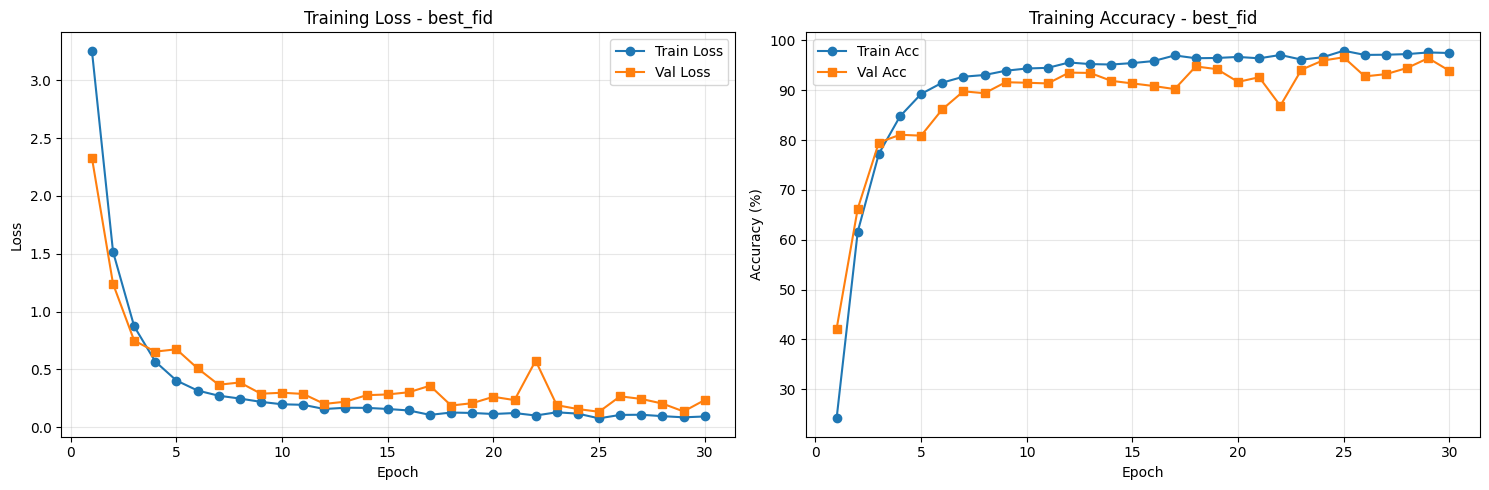


GENERATING CONFUSION MATRIX

PER-CLASS PERFORMANCE ANALYSIS

📊 Top 10 Best Performing Subjects:
--------------------------------------------------
 1. Subject   1: 100.00% accuracy
 2. Subject   4: 100.00% accuracy
 3. Subject   5: 100.00% accuracy
 4. Subject  10: 100.00% accuracy
 5. Subject  12: 100.00% accuracy
 6. Subject  16: 100.00% accuracy
 7. Subject  19: 100.00% accuracy
 8. Subject  25: 100.00% accuracy
 9. Subject  26: 100.00% accuracy
10. Subject  27: 100.00% accuracy

⚠️  Top 10 Worst Performing Subjects:
--------------------------------------------------
 1. Subject  62:  93.10% accuracy
 2. Subject  21:  90.00% accuracy
 3. Subject   3:  89.66% accuracy
 4. Subject  68:  89.66% accuracy
 5. Subject   8:  86.21% accuracy
 6. Subject  22:  86.21% accuracy
 7. Subject  48:  86.21% accuracy
 8. Subject  86:  86.21% accuracy
 9. Subject   7:  82.76% accuracy
10. Subject  17:  81.48% accuracy

📈 Overall Statistics:
--------------------------------------------------
Mean per

/tmp/ipykernel_355/3377844112.py:165: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



✓ Confusion matrix saved: results/confusion_matrix_best_fid.png


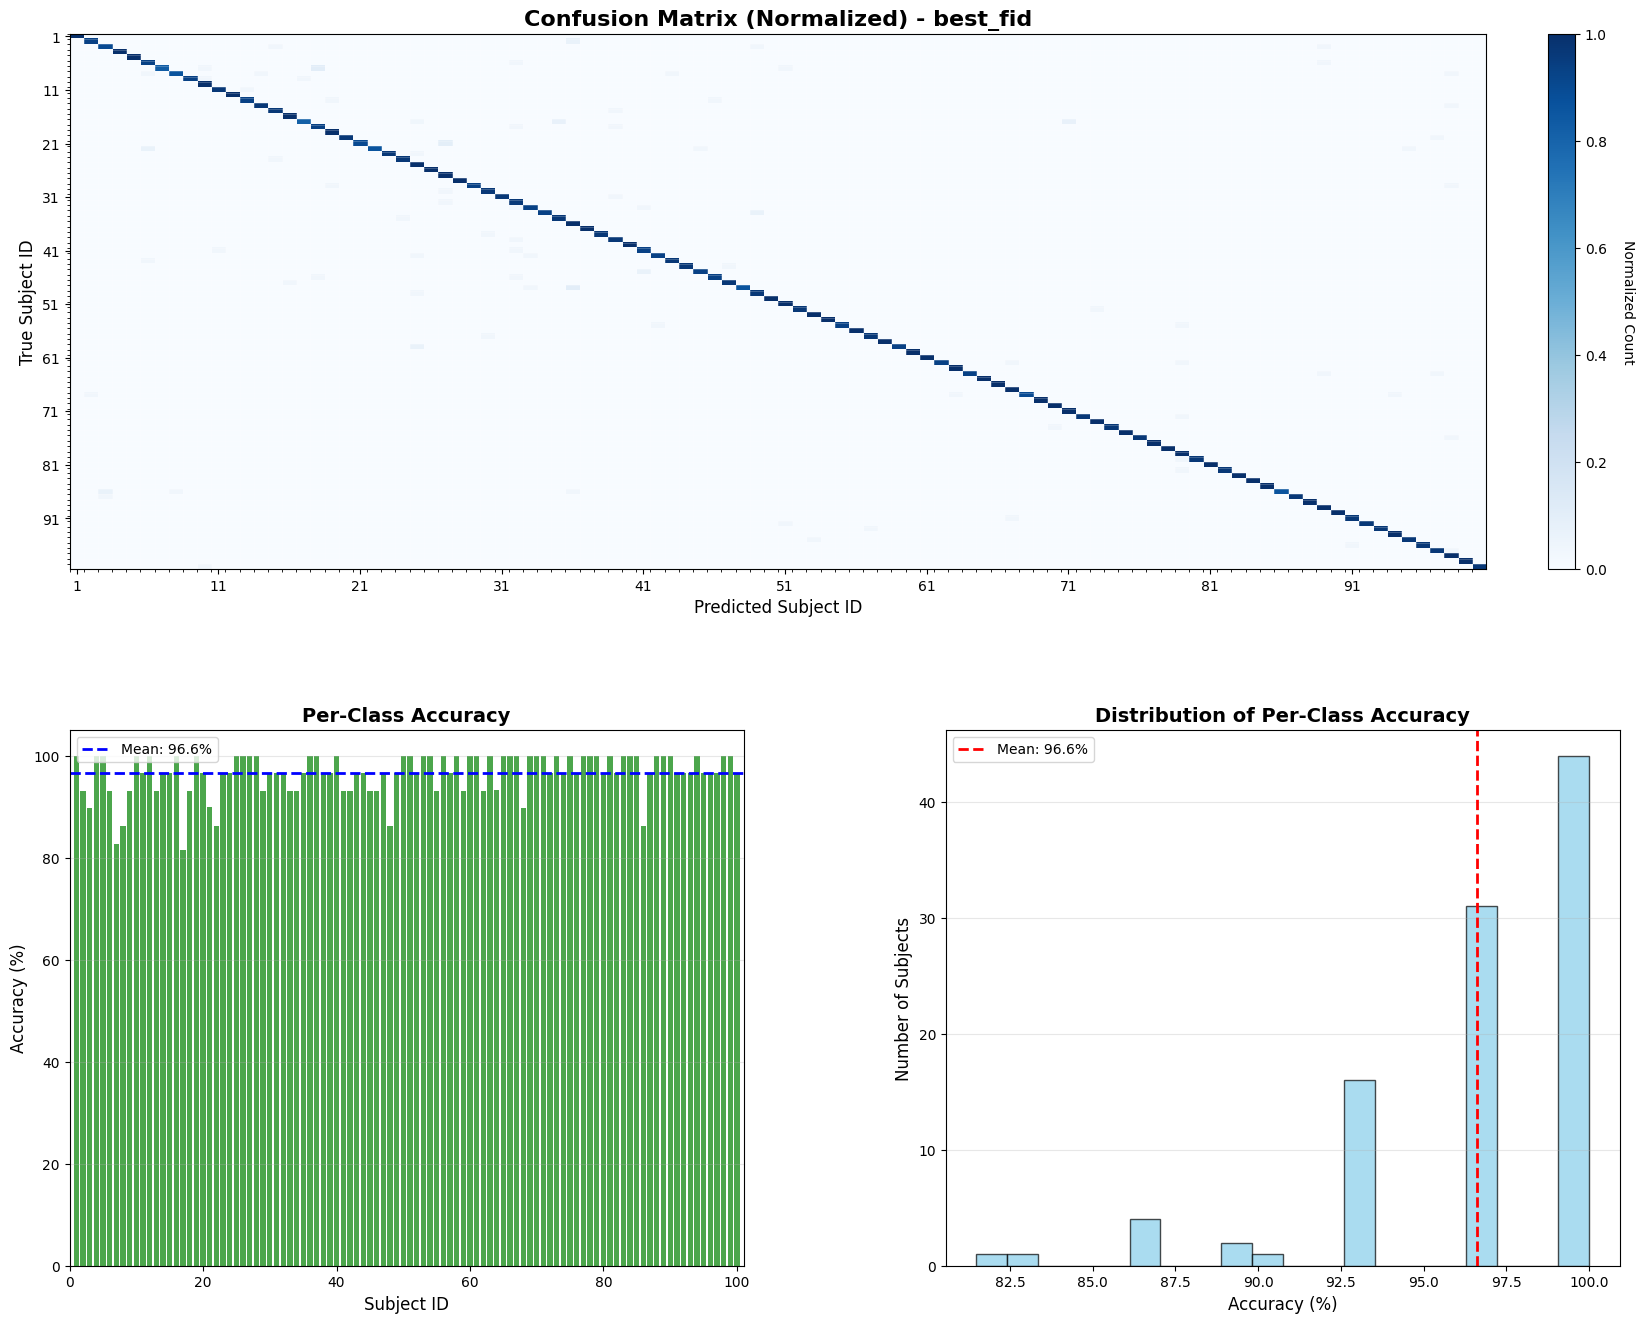

✓ Per-class accuracy saved: results/per_class_accuracy_best_fid.csv

TRAINING PIPELINE COMPLETED SUCCESSFULLY!
All outputs saved to: results
Model: best_fid
Final Test Accuracy: 96.62%
Mean Per-Class Accuracy: 96.61%


In [30]:
def main():
    """Main training pipeline"""

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n✓ Using device: {device}")
    if torch.cuda.is_available():
        print(f"  GPU: {torch.cuda.get_device_name(0)}")
        print(
            f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB"
        )
    else:
        print(f"  ⚠ No GPU detected - training will be slower on CPU")
        print(f"  💡 Consider using Google Colab with GPU runtime for faster training")

    # Load dataset
    print(f"\nLoading dataset: {CURRENT_MODEL}")
    dataset_path = DATASET_PATHS[CURRENT_MODEL]
    df = load_dataset(dataset_path, exclude_bad=EXCLUDE_BAD_IMAGES)

    # Prepare data loaders
    print("\nPreparing data loaders...")
    train_loader, val_loader, test_loader, splits_info = prepare_data_loaders(
        df, BATCH_SIZE, NUM_WORKERS, AUGMENTATION_CONFIG
    )

    # Create model
    print(f"\nCreating DenseNet-{DENSENET_VERSION} model...")
    model = create_densenet_classifier(NUM_CLASSES, USE_PRETRAINED, DENSENET_VERSION)
    model = model.to(device)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"✓ Total parameters: {total_params:,}")
    print(f"✓ Trainable parameters: {trainable_params:,}")

    # Train model
    print("\n" + "=" * 60)
    print("STARTING TRAINING")
    print("=" * 60)

    history = train_model(
        model,
        train_loader,
        val_loader,
        device,
        CURRENT_MODEL,
        config={
            "num_epochs": NUM_EPOCHS,
            "learning_rate": LEARNING_RATE,
            "batch_size": BATCH_SIZE,
        },
    )

    # Load best model for evaluation
    best_model_path = os.path.join(OUTPUT_DIR, f"best_model_{CURRENT_MODEL}.pth")
    if os.path.exists(best_model_path):
        print(f"\nLoading best model for evaluation...")
        checkpoint = torch.load(
            best_model_path, map_location=device
        )  # map_location for CPU compatibility
        model.load_state_dict(checkpoint["model_state_dict"])
        print(
            f"✓ Loaded best model from epoch {checkpoint['epoch']} (Val Acc: {checkpoint['val_acc']:.2f}%)"
        )

    # Evaluate on test set
    print("\n" + "=" * 60)
    print("EVALUATING ON TEST SET")
    print("=" * 60)

    results = evaluate_model(model, test_loader, device, CURRENT_MODEL)

    print(f"\nTest Results for {CURRENT_MODEL}:")
    print("-" * 50)
    print(f"Accuracy:       {results['accuracy']:.2f}%")
    print(f"Top-5 Accuracy: {results['top5_accuracy']:.2f}%")
    print(f"Precision:      {results['precision']:.2f}%")
    print(f"Recall:         {results['recall']:.2f}%")
    print(f"F1-Score:       {results['f1_score']:.2f}%")
    print("-" * 50)

    # Save results
    save_results(results, history, CURRENT_MODEL)

    # Plot training curves
    plot_training_curves(history, CURRENT_MODEL)

    # Plot confusion matrix and per-class analysis
    print("\n" + "=" * 60)
    print("GENERATING CONFUSION MATRIX")
    print("=" * 60)
    cm, per_class_acc = plot_confusion_matrix(
        results, CURRENT_MODEL, num_classes=NUM_CLASSES
    )

    print("\n" + "=" * 60)
    print("TRAINING PIPELINE COMPLETED SUCCESSFULLY!")
    print("=" * 60)
    print(f"All outputs saved to: {OUTPUT_DIR}")
    print(f"Model: {CURRENT_MODEL}")
    print(f"Final Test Accuracy: {results['accuracy']:.2f}%")
    print(f"Mean Per-Class Accuracy: {np.mean(per_class_acc)*100:.2f}%")
    print("=" * 60)


# Run main pipeline
if __name__ == "__main__":
    main()

In [ ]:
CURRENT_MODEL = "best_fid"  # Change this for each training run

DATASET_PATHS = {
    "original": "/content/drive/MyDrive/Mobius_Dataset/MOBIUS/Images",
    "best_fid": "/content/drive/MyDrive/Mobius_Dataset/MOBIUS_BEST_FID_GENERATED/Images",
    "latest_fid": "/content/drive/MyDrive/Mobius_Dataset/MOBIUS_LATEST_FID_GENERATED/Images",
}

OUTPUT_DIR = "/content/drive/MyDrive/Mobius_Dataset/results/results_best_fid"

# DenseNet variant: '121', '169', '201', or '161' (DenseNet-161 is actually called densenet161)
DENSENET_VERSION = "121"

# Number of classes (subjects)
NUM_CLASSES = 100

# Use ImageNet pretrained weights
USE_PRETRAINED = True

# Training parameters
NUM_EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4

# Data split ratios
TEST_SIZE = 0.15
VAL_SIZE = 0.15
RANDOM_SEED = 42

# Learning rate scheduler
LR_SCHEDULER_PATIENCE = 5  # Reduce LR if no improvement for N epochs
LR_SCHEDULER_FACTOR = 0.5  # Multiply LR by this factor

# Early stopping
EARLY_STOPPING_PATIENCE = 15  # Stop if no improvement for N epochs

# Checkpoint settings
CHECKPOINT_FREQUENCY = 5  # Save checkpoint every N epochs
AUTO_SAVE_BEST = True  # Automatically save best model
RESUME_TRAINING = True  # Resume from last checkpoint if available

# Augmentation parameters
AUGMENTATION_CONFIG = {
    "resize": (256, 256),
    "crop_size": 224,
    "random_horizontal_flip": True,
    "flip_probability": 0.3,  # Be careful: might flip left/right eye
    "random_rotation_degrees": 10,
    "color_jitter": {"brightness": 0.2, "contrast": 0.2, "saturation": 0.2, "hue": 0.0},
}

# Number of workers for data loading
NUM_WORKERS = 4  # Set to 0 for CPU, 2-4 for GPU

# Mixed precision training (faster on T4/A100 GPUs)
USE_AMP = True  # Automatic Mixed Precision

# Exclude images marked as 'bad' in filename
EXCLUDE_BAD_IMAGES = True

# Mount Google Drive (will be handled in main code)
MOUNT_DRIVE = True

# Keep session alive settings
COLAB_KEEPALIVE = True  # Print progress to prevent timeout

print("=" * 60)
print(f"Configuration loaded for: {CURRENT_MODEL.upper()}")
print("=" * 60)
print(f"Dataset path: {DATASET_PATHS[CURRENT_MODEL]}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"DenseNet version: {DENSENET_VERSION}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Number of epochs: {NUM_EPOCHS}")
print(f"Resume training: {RESUME_TRAINING}")
print("=" * 60)

In [ ]:
import sys
try:
    import torch
    import torchvision
    from sklearn.model_selection import train_test_split
    from tqdm import tqdm
    print("✓ All packages already installed")
except ImportError:
    print("Installing required packages...")
    !pip install torch torchvision scikit-learn tqdm pillow pandas matplotlib seaborn -q
    print("✓ Packages installed successfully")

import os
import re
import json
import time
from datetime import datetime
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from tqdm.auto import tqdm

In [ ]:
def parse_filename(filename):
    """
    Parse MOBIUS filename to extract metadata
    Supports two formats:
    1. Original: '23_2i_Ls_1.jpg' -> {id: 23, phone: 2, light: 'i', eye: 'L', gaze: 's', number: '1'}
    2. Generated: 'generated_20.jpg' -> {id: extracted from parent folder, is_generated: True}
    """
    # Try original MOBIUS format first
    pattern_original = r"(\d+)_(\d)([inp])_([LR])([lrsu])_(\d+|bad)\.jpg"
    match = re.match(pattern_original, filename)

    if match:
        return {
            "subject_id": int(match.group(1)),
            "phone": int(match.group(2)),
            "light": match.group(3),
            "eye": match.group(4),
            "gaze": match.group(5),
            "number": match.group(6),
            "is_generated": False,
        }

    # Try generated image format: 'generated_20.jpg', 'generated_5.jpg', etc.
    pattern_generated = r"generated_\d+\.jpg"
    if re.match(pattern_generated, filename):
        # Subject ID will be extracted from parent folder name
        return {"is_generated": True, "filename_type": "generated"}

    return None


def load_dataset(data_dir, exclude_bad=True):
    """
    Load all images and extract metadata from a directory containing subject subfolders.
    Handles both original MOBIUS naming and generated image naming conventions.

    Args:
        data_dir: Path to the main image directory (containing subject subfolders).
        exclude_bad: Whether to exclude images marked as 'bad'.

    Returns:
        DataFrame with image paths and metadata.
    """
    if not os.path.exists(data_dir):
        raise ValueError(f"Dataset directory not found: {data_dir}")

    data = []
    subject_subdirs = [
        d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))
    ]

    if not subject_subdirs:
        raise ValueError(
            f"No subject subfolders found in {data_dir}. Expected 100 folders."
        )

    # Track statistics
    original_count = 0
    generated_count = 0

    for subdir in tqdm(subject_subdirs, desc="Loading subjects", leave=False):
        subdir_path = os.path.join(data_dir, subdir)

        # Extract subject ID from folder name (assuming folder name is the subject ID)
        try:
            folder_subject_id = int(subdir)
        except ValueError:
            print(
                f"⚠ Warning: Folder '{subdir}' doesn't appear to be a numeric subject ID, skipping..."
            )
            continue

        image_files = [f for f in os.listdir(subdir_path) if f.endswith(".jpg")]

        for filename in image_files:
            metadata = parse_filename(filename)

            if metadata:
                # For generated images, use folder name as subject_id
                if metadata.get("is_generated"):
                    metadata["subject_id"] = folder_subject_id
                    metadata["phone"] = None
                    metadata["light"] = None
                    metadata["eye"] = None
                    metadata["gaze"] = None
                    metadata["number"] = "generated"
                    generated_count += 1
                else:
                    # Verify subject_id matches folder name for original images
                    if metadata["subject_id"] != folder_subject_id:
                        print(
                            f"⚠ Warning: Subject ID mismatch - File '{filename}' (ID: {metadata['subject_id']}) in folder '{subdir}' (ID: {folder_subject_id})"
                        )

                    # Exclude bad images
                    if exclude_bad and metadata["number"] == "bad":
                        continue

                    original_count += 1

                metadata["filename"] = filename
                metadata["path"] = os.path.join(subdir_path, filename)
                data.append(metadata)

    if len(data) == 0:
        raise ValueError(f"No .jpg images found in any subfolder of {data_dir}")

    df = pd.DataFrame(data)

    print(f"✓ Loaded {len(df)} images from {len(df['subject_id'].unique())} subjects")
    if original_count > 0 and generated_count > 0:
        print(f"  - Original images: {original_count}")
        print(f"  - Generated images: {generated_count}")
        print(
            f"  - Mix ratio: {original_count/(original_count+generated_count)*100:.1f}% original, {generated_count/(original_count+generated_count)*100:.1f}% generated"
        )
    elif generated_count > 0:
        print(f"  - All images are generated")
    else:
        print(f"  - All images are original")

    return df


def save_checkpoint(
    model, optimizer, scheduler, epoch, val_acc, history, checkpoint_path, is_best=False
):
    """Save training checkpoint"""
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict() if scheduler else None,
        "val_acc": val_acc,
        "history": history,
        "timestamp": datetime.now().isoformat(),
    }

    torch.save(checkpoint, checkpoint_path)

    if is_best:
        best_path = checkpoint_path.replace("checkpoint", "best_model")
        torch.save(checkpoint, best_path)
        print(f"  ✓ Best model saved: {best_path}")


def load_checkpoint(checkpoint_path, model, optimizer=None, scheduler=None):
    """
    Load training checkpoint
    Compatible with both GPU and CPU
    """
    if not os.path.exists(checkpoint_path):
        return None

    print(f"Loading checkpoint from: {checkpoint_path}")

    # Load with map_location for CPU compatibility
    device = next(model.parameters()).device
    checkpoint = torch.load(checkpoint_path, map_location=device)

    model.load_state_dict(checkpoint["model_state_dict"])

    if optimizer and "optimizer_state_dict" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    if scheduler and checkpoint.get("scheduler_state_dict"):
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

    print(
        f"✓ Resumed from epoch {checkpoint['epoch']} (Val Acc: {checkpoint['val_acc']:.2f}%)"
    )

    return checkpoint

In [ ]:
class MobiusDataset(Dataset):
    """MOBIUS Eye Dataset"""

    def __init__(self, image_paths, labels, transform=None):
        """
        Args:
            image_paths: List of image file paths
            labels: List of subject IDs (0-99)
            transform: torchvision transforms
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image as fallback
            image = Image.new("RGB", (224, 224), color="black")

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]

        return image, label

In [ ]:
def prepare_data_loaders(df, batch_size, num_workers, augmentation_config):
    """
    Prepare train, validation, and test data loaders

    Returns:
        train_loader, val_loader, test_loader, splits_info
    """
    # Split data
    train_val_df, test_df = train_test_split(
        df, test_size=TEST_SIZE, stratify=df["subject_id"], random_state=RANDOM_SEED
    )

    val_ratio = VAL_SIZE / (1 - TEST_SIZE)
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_ratio,
        stratify=train_val_df["subject_id"],
        random_state=RANDOM_SEED,
    )

    print(
        f"✓ Data split - Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}"
    )

    # Define transforms
    train_transform = transforms.Compose(
        [
            transforms.Resize(augmentation_config["resize"]),
            transforms.RandomCrop(augmentation_config["crop_size"]),
            (
                transforms.RandomHorizontalFlip(
                    p=augmentation_config["flip_probability"]
                )
                if augmentation_config["random_horizontal_flip"]
                else transforms.Lambda(lambda x: x)
            ),
            transforms.RandomRotation(
                degrees=augmentation_config["random_rotation_degrees"]
            ),
            transforms.ColorJitter(**augmentation_config["color_jitter"]),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    val_test_transform = transforms.Compose(
        [
            transforms.Resize(
                (augmentation_config["crop_size"], augmentation_config["crop_size"])
            ),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    # Create datasets
    train_dataset = MobiusDataset(
        train_df["path"].tolist(),
        (train_df["subject_id"] - 1).tolist(),  # Convert to 0-indexed
        transform=train_transform,
    )

    val_dataset = MobiusDataset(
        val_df["path"].tolist(),
        (val_df["subject_id"] - 1).tolist(),
        transform=val_test_transform,
    )

    test_dataset = MobiusDataset(
        test_df["path"].tolist(),
        (test_df["subject_id"] - 1).tolist(),
        transform=val_test_transform,
    )

    # Create data loaders with CPU-compatible settings
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=(
            num_workers if torch.cuda.is_available() else 0
        ),  # Use 0 workers on CPU
        pin_memory=(
            True if torch.cuda.is_available() else False
        ),  # Only pin memory on GPU
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers if torch.cuda.is_available() else 0,
        pin_memory=True if torch.cuda.is_available() else False,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers if torch.cuda.is_available() else 0,
        pin_memory=True if torch.cuda.is_available() else False,
    )

    splits_info = {"train_df": train_df, "val_df": val_df, "test_df": test_df}

    return train_loader, val_loader, test_loader, splits_info

In [ ]:
def create_densenet_classifier(num_classes, pretrained, densenet_version):
    """
    Create DenseNet model for classification

    Args:
        num_classes: Number of output classes
        pretrained: Use ImageNet pretrained weights
        densenet_version: '121', '169', '201', or '161'

    Returns:
        DenseNet model
    """
    if densenet_version == "121":
        model = models.densenet121(pretrained=pretrained)
    elif densenet_version == "169":
        model = models.densenet169(pretrained=pretrained)
    elif densenet_version == "201":
        model = models.densenet201(pretrained=pretrained)
    elif densenet_version == "161":
        model = models.densenet161(pretrained=pretrained)
    else:
        raise ValueError(f"Invalid DenseNet version: {densenet_version}")

    # Replace final classification layer
    num_features = model.classifier.in_features
    model.classifier = nn.Linear(num_features, num_classes)

    return model

In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, device, scaler=None):
    """
    Train for one epoch
    Compatible with both GPU (CUDA) and CPU
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc="Training", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Mixed precision training (only if scaler is provided and on CUDA)
        if scaler and torch.cuda.is_available():
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # Standard training (CPU or no AMP)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar
        pbar.set_postfix(
            {
                "loss": f"{running_loss/(pbar.n+1):.3f}",
                "acc": f"{100.*correct/total:.2f}%",
            }
        )

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100.0 * correct / total

    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device):
    """Validate model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_acc = 100.0 * correct / total

    return val_loss, val_acc


def train_model(model, train_loader, val_loader, device, model_name, config):
    """
    Complete training loop with checkpointing

    Returns:
        Training history
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="max",
        factor=LR_SCHEDULER_FACTOR,
        patience=LR_SCHEDULER_PATIENCE,
        # Removed 'verbose=True' as it's deprecated in newer PyTorch versions
    )

    # Mixed precision scaler (only for CUDA)
    scaler = (
        torch.cuda.amp.GradScaler() if USE_AMP and torch.cuda.is_available() else None
    )

    if scaler:
        print(f"✓ Using Automatic Mixed Precision (AMP) for faster training")
    else:
        if not torch.cuda.is_available():
            print(f"ℹ Running on CPU - AMP disabled")
        else:
            print(f"ℹ AMP disabled in configuration")

    # Checkpoint path
    checkpoint_path = os.path.join(OUTPUT_DIR, f"checkpoint_{model_name}.pth")

    # Try to resume
    start_epoch = 0
    best_val_acc = 0.0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if RESUME_TRAINING and os.path.exists(checkpoint_path):
        checkpoint = load_checkpoint(checkpoint_path, model, optimizer, scheduler)
        if checkpoint:
            start_epoch = checkpoint["epoch"] + 1
            best_val_acc = checkpoint["val_acc"]
            history = checkpoint["history"]
            print(f"✓ Resuming training from epoch {start_epoch}")

    # Early stopping
    patience_counter = 0

    print(f"\n{'='*60}")
    print(f"Starting training: {model_name}")
    print(f"Device: {device}")
    if torch.cuda.is_available():
        print(f"Mixed Precision (AMP): {USE_AMP}")
    else:
        print(f"Running on CPU (AMP not available)")
    print(f"{'='*60}\n")

    for epoch in range(start_epoch, NUM_EPOCHS):
        epoch_start_time = time.time()

        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        print("-" * 50)

        # Train
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device, scaler
        )

        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        # Update scheduler
        scheduler.step(val_acc)

        # Save history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        epoch_time = time.time() - epoch_start_time

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        print(f"Time: {epoch_time:.2f}s")

        # Save checkpoint
        is_best = val_acc > best_val_acc

        if is_best:
            best_val_acc = val_acc
            patience_counter = 0
            print(f"✓ New best validation accuracy: {val_acc:.2f}%")
        else:
            patience_counter += 1

        # Save regular checkpoint
        if (epoch + 1) % CHECKPOINT_FREQUENCY == 0 or is_best:
            save_checkpoint(
                model,
                optimizer,
                scheduler,
                epoch,
                val_acc,
                history,
                checkpoint_path,
                is_best=is_best,
            )
            print(f"  ✓ Checkpoint saved")

        # Early stopping
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(
                f"\n⚠ Early stopping triggered (no improvement for {EARLY_STOPPING_PATIENCE} epochs)"
            )
            break

        # Keep-alive for Colab
        if COLAB_KEEPALIVE:
            print(
                f'[Keep-Alive] Epoch {epoch+1} completed at {datetime.now().strftime("%H:%M:%S")}'
            )

    # Save final checkpoint
    save_checkpoint(
        model,
        optimizer,
        scheduler,
        epoch,
        val_acc,
        history,
        checkpoint_path,
        is_best=False,
    )

    print(f'\n{"="*60}')
    print(f"Training completed!")
    print(f"Best validation accuracy: {best_val_acc:.2f}%")
    print(f'{"="*60}\n')

    return history

In [ ]:
def evaluate_model(model, test_loader, device, model_name):
    """
    Comprehensive evaluation on test set

    Returns:
        Dictionary with metrics
    """
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Testing {model_name}"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="macro", zero_division=0
    )

    # Top-5 accuracy
    top5_correct = 0
    for i, label in enumerate(all_labels):
        top5_preds = np.argsort(all_probs[i])[-5:]
        if label in top5_preds:
            top5_correct += 1
    top5_accuracy = top5_correct / len(all_labels)

    results = {
        "accuracy": accuracy * 100,
        "precision": precision * 100,
        "recall": recall * 100,
        "f1_score": f1 * 100,
        "top5_accuracy": top5_accuracy * 100,
        "predictions": all_preds,
        "labels": all_labels,
        "probabilities": all_probs,
    }

    return results


def save_results(results, history, model_name):
    """Save results and training history"""
    results_dir = os.path.join(OUTPUT_DIR, f"results_{model_name}")
    os.makedirs(results_dir, exist_ok=True)

    # Save metrics
    metrics = {
        "accuracy": float(results["accuracy"]),
        "top5_accuracy": float(results["top5_accuracy"]),
        "precision": float(results["precision"]),
        "recall": float(results["recall"]),
        "f1_score": float(results["f1_score"]),
    }

    with open(os.path.join(results_dir, "metrics.json"), "w") as f:
        json.dump(metrics, f, indent=4)

    # Save history
    with open(os.path.join(results_dir, "history.json"), "w") as f:
        json.dump(history, f, indent=4)

    # Save predictions
    np.save(os.path.join(results_dir, "predictions.npy"), results["predictions"])
    np.save(os.path.join(results_dir, "labels.npy"), results["labels"])
    np.save(os.path.join(results_dir, "probabilities.npy"), results["probabilities"])

    print(f"✓ Results saved to: {results_dir}")

In [ ]:
def plot_training_curves(history, model_name):
    """Plot and save training curves"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    epochs = range(1, len(history["train_loss"]) + 1)

    # Loss
    axes[0].plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    axes[0].plot(epochs, history["val_loss"], label="Val Loss", marker="s")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title(f"Training Loss - {model_name}")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy
    axes[1].plot(epochs, history["train_acc"], label="Train Acc", marker="o")
    axes[1].plot(epochs, history["val_acc"], label="Val Acc", marker="s")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy (%)")
    axes[1].set_title(f"Training Accuracy - {model_name}")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()

    save_path = os.path.join(OUTPUT_DIR, f"training_curves_{model_name}.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"✓ Training curves saved: {save_path}")
    plt.show()


def plot_confusion_matrix(results, model_name, num_classes=100):
    """
    Plot and save detailed confusion matrix

    Args:
        results: Dictionary containing predictions and labels
        model_name: Name of the model for saving
        num_classes: Number of classes (default: 100)
    """
    from sklearn.metrics import confusion_matrix

    # Compute confusion matrix
    cm = confusion_matrix(
        results["labels"], results["predictions"], labels=range(num_classes)
    )

    # Calculate per-class accuracy
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    per_class_accuracy = np.nan_to_num(
        per_class_accuracy, nan=0.0
    )  # Handle division by zero

    print("\n" + "=" * 60)
    print("PER-CLASS PERFORMANCE ANALYSIS")
    print("=" * 60)

    # Find best and worst performing classes
    class_accuracies = [(i + 1, acc * 100) for i, acc in enumerate(per_class_accuracy)]
    class_accuracies.sort(key=lambda x: x[1], reverse=True)

    print("\n📊 Top 10 Best Performing Subjects:")
    print("-" * 50)
    for i, (subject_id, acc) in enumerate(class_accuracies[:10], 1):
        print(f"{i:2d}. Subject {subject_id:3d}: {acc:6.2f}% accuracy")

    print("\n⚠️  Top 10 Worst Performing Subjects:")
    print("-" * 50)
    for i, (subject_id, acc) in enumerate(class_accuracies[-10:], 1):
        print(f"{i:2d}. Subject {subject_id:3d}: {acc:6.2f}% accuracy")

    # Overall statistics
    print("\n📈 Overall Statistics:")
    print("-" * 50)
    print(f"Mean per-class accuracy: {np.mean(per_class_accuracy)*100:.2f}%")
    print(f"Std per-class accuracy:  {np.std(per_class_accuracy)*100:.2f}%")
    print(f"Min per-class accuracy:  {np.min(per_class_accuracy)*100:.2f}%")
    print(f"Max per-class accuracy:  {np.max(per_class_accuracy)*100:.2f}%")

    # Count samples per class
    samples_per_class = cm.sum(axis=1)
    print(
        f"\nSamples per class - Min: {samples_per_class.min()}, Max: {samples_per_class.max()}, Mean: {samples_per_class.mean():.1f}"
    )

    # Create visualizations
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

    # 1. Full confusion matrix (100x100)
    ax1 = fig.add_subplot(gs[0, :])

    # Normalize confusion matrix by row (true labels)
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized, nan=0.0)

    im = ax1.imshow(cm_normalized, cmap="Blues", aspect="auto", interpolation="nearest")
    ax1.set_title(
        f"Confusion Matrix (Normalized) - {model_name}", fontsize=16, fontweight="bold"
    )
    ax1.set_xlabel("Predicted Subject ID", fontsize=12)
    ax1.set_ylabel("True Subject ID", fontsize=12)

    # Set ticks
    tick_marks = np.arange(0, num_classes, 10)
    ax1.set_xticks(tick_marks)
    ax1.set_yticks(tick_marks)
    ax1.set_xticklabels([str(i + 1) for i in tick_marks])
    ax1.set_yticklabels([str(i + 1) for i in tick_marks])

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    cbar.set_label("Normalized Count", rotation=270, labelpad=20)

    # Add grid
    ax1.set_xticks(np.arange(num_classes) - 0.5, minor=True)
    ax1.set_yticks(np.arange(num_classes) - 0.5, minor=True)
    ax1.grid(which="minor", color="white", linestyle="-", linewidth=0.5, alpha=0.3)

    # 2. Per-class accuracy bar chart
    ax2 = fig.add_subplot(gs[1, 0])

    colors = [
        "green" if acc > 0.8 else "orange" if acc > 0.5 else "red"
        for acc in per_class_accuracy
    ]
    bars = ax2.bar(
        range(1, num_classes + 1), per_class_accuracy * 100, color=colors, alpha=0.7
    )
    ax2.axhline(
        y=np.mean(per_class_accuracy) * 100,
        color="blue",
        linestyle="--",
        linewidth=2,
        label=f"Mean: {np.mean(per_class_accuracy)*100:.1f}%",
    )
    ax2.set_xlabel("Subject ID", fontsize=12)
    ax2.set_ylabel("Accuracy (%)", fontsize=12)
    ax2.set_title("Per-Class Accuracy", fontsize=14, fontweight="bold")
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis="y")
    ax2.set_xlim(0, num_classes + 1)
    ax2.set_ylim(0, 105)

    # 3. Accuracy distribution histogram
    ax3 = fig.add_subplot(gs[1, 1])

    ax3.hist(
        per_class_accuracy * 100, bins=20, color="skyblue", edgecolor="black", alpha=0.7
    )
    ax3.axvline(
        x=np.mean(per_class_accuracy) * 100,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Mean: {np.mean(per_class_accuracy)*100:.1f}%",
    )
    ax3.set_xlabel("Accuracy (%)", fontsize=12)
    ax3.set_ylabel("Number of Subjects", fontsize=12)
    ax3.set_title("Distribution of Per-Class Accuracy", fontsize=14, fontweight="bold")
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis="y")

    plt.tight_layout()

    # Save confusion matrix visualization
    save_path = os.path.join(OUTPUT_DIR, f"confusion_matrix_{model_name}.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"\n✓ Confusion matrix saved: {save_path}")
    plt.show()

    # Save per-class accuracy as CSV
    accuracy_df = pd.DataFrame(
        {
            "Subject_ID": range(1, num_classes + 1),
            "Accuracy_%": per_class_accuracy * 100,
            "Samples": samples_per_class,
        }
    )
    accuracy_df = accuracy_df.sort_values("Accuracy_%", ascending=False)

    csv_path = os.path.join(OUTPUT_DIR, f"per_class_accuracy_{model_name}.csv")
    accuracy_df.to_csv(csv_path, index=False)
    print(f"✓ Per-class accuracy saved: {csv_path}")

    # Return confusion matrix for further analysis
    return cm, per_class_accuracy

In [ ]:
def main():
    """Main training pipeline"""

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n✓ Using device: {device}")
    if torch.cuda.is_available():
        print(f"  GPU: {torch.cuda.get_device_name(0)}")
        print(
            f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB"
        )
    else:
        print(f"  ⚠ No GPU detected - training will be slower on CPU")
        print(f"  💡 Consider using Google Colab with GPU runtime for faster training")

    # Load dataset
    print(f"\nLoading dataset: {CURRENT_MODEL}")
    dataset_path = DATASET_PATHS[CURRENT_MODEL]
    df = load_dataset(dataset_path, exclude_bad=EXCLUDE_BAD_IMAGES)

    # Prepare data loaders
    print("\nPreparing data loaders...")
    train_loader, val_loader, test_loader, splits_info = prepare_data_loaders(
        df, BATCH_SIZE, NUM_WORKERS, AUGMENTATION_CONFIG
    )

    # Create model
    print(f"\nCreating DenseNet-{DENSENET_VERSION} model...")
    model = create_densenet_classifier(NUM_CLASSES, USE_PRETRAINED, DENSENET_VERSION)
    model = model.to(device)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"✓ Total parameters: {total_params:,}")
    print(f"✓ Trainable parameters: {trainable_params:,}")

    # Train model
    print("\n" + "=" * 60)
    print("STARTING TRAINING")
    print("=" * 60)

    history = train_model(
        model,
        train_loader,
        val_loader,
        device,
        CURRENT_MODEL,
        config={
            "num_epochs": NUM_EPOCHS,
            "learning_rate": LEARNING_RATE,
            "batch_size": BATCH_SIZE,
        },
    )

    # Load best model for evaluation
    best_model_path = os.path.join(OUTPUT_DIR, f"best_model_{CURRENT_MODEL}.pth")
    if os.path.exists(best_model_path):
        print(f"\nLoading best model for evaluation...")
        checkpoint = torch.load(
            best_model_path, map_location=device
        )  # map_location for CPU compatibility
        model.load_state_dict(checkpoint["model_state_dict"])
        print(
            f"✓ Loaded best model from epoch {checkpoint['epoch']} (Val Acc: {checkpoint['val_acc']:.2f}%)"
        )

    # Evaluate on test set
    print("\n" + "=" * 60)
    print("EVALUATING ON TEST SET")
    print("=" * 60)

    results = evaluate_model(model, test_loader, device, CURRENT_MODEL)

    print(f"\nTest Results for {CURRENT_MODEL}:")
    print("-" * 50)
    print(f"Accuracy:       {results['accuracy']:.2f}%")
    print(f"Top-5 Accuracy: {results['top5_accuracy']:.2f}%")
    print(f"Precision:      {results['precision']:.2f}%")
    print(f"Recall:         {results['recall']:.2f}%")
    print(f"F1-Score:       {results['f1_score']:.2f}%")
    print("-" * 50)

    # Save results
    save_results(results, history, CURRENT_MODEL)

    # Plot training curves
    plot_training_curves(history, CURRENT_MODEL)

    # Plot confusion matrix and per-class analysis
    print("\n" + "=" * 60)
    print("GENERATING CONFUSION MATRIX")
    print("=" * 60)
    cm, per_class_acc = plot_confusion_matrix(
        results, CURRENT_MODEL, num_classes=NUM_CLASSES
    )

    print("\n" + "=" * 60)
    print("TRAINING PIPELINE COMPLETED SUCCESSFULLY!")
    print("=" * 60)
    print(f"All outputs saved to: {OUTPUT_DIR}")
    print(f"Model: {CURRENT_MODEL}")
    print(f"Final Test Accuracy: {results['accuracy']:.2f}%")
    print(f"Mean Per-Class Accuracy: {np.mean(per_class_acc)*100:.2f}%")
    print("=" * 60)


# Run main pipeline
if __name__ == "__main__":
    main()


✓ Using device: cuda
  GPU: Tesla T4
  Memory: 15.83 GB

Loading dataset: latest_fid


ValueError: Dataset directory not found: /content/drive/MyDrive/Mobius_Dataset/MOBIUS_LATEST_FID_GENERATED/Images